In [13]:
pip install pydub

In [14]:
pip install tqdm

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
pip install librosa scikit-learn keras tensorflow

In [17]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import Callback

In [18]:
class PrintTrainingProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{self.params['epochs']} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

In [19]:
def extract_features(audio_file, sample_rate=44100, n_mfcc=13, max_len=174):
    audio_data, _ = librosa.load(audio_file, sr=sample_rate)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    # Pad or truncate the features to have fixed length
    if (mfccs.shape[1] < max_len):
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]
    return mfccs

In [20]:
def load_data(data_dir):
    print("Step 1: Loading data...")
    labels = []
    features = []
    for class_dir in os.listdir(data_dir):
        class_label = class_dir
        class_dir_path = os.path.join(data_dir, class_dir)
        for audio_file in os.listdir(class_dir_path):
            file_path = os.path.join(class_dir_path, audio_file)
            # Extract features
            mfccs = extract_features(file_path)
            features.append(mfccs)
            labels.append(class_label)
    print("Data loaded successfully.")
    return np.array(features), np.array(labels)

In [21]:
# Load data
print("Step 2: Preprocessing data and encoding labels...")
data_dir = '/content/drive/MyDrive/wav'  # Change this to your directory containing audio files
features, labels = load_data(data_dir)

# Encode labels
print("Encoding labels...")
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
encoded_labels = to_categorical(encoded_labels, num_classes=num_classes)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
print("Data preprocessed and labels encoded.")

Step 2: Preprocessing data and encoding labels...
Step 1: Loading data...
Data loaded successfully.
Encoding labels...
Data preprocessed and labels encoded.


In [22]:
# Reshape input data to include the channel dimension
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [33]:
# Define CNN model
print("Step 3: Building the model...")
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


Step 3: Building the model...


In [35]:
# Compile the model
print("Compiling the model...")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print("Model built and compiled successfully.")
# Print model summary
print("Model Summary:")
print(model.summary())

# Define callback to print training progress
print_progress = PrintTrainingProgress()

# Train the model with the callback
print("Step 4: Training the model...")
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), callbacks=[print_progress])
print("Model trained successfully.")

# Evaluate the model
print("Step 5: Evaluating the model...")
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print("Model evaluation complete.")

Compiling the model...
Model built and compiled successfully.
Model Summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 11, 172, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 86, 32)         0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 5, 86, 32)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 84, 64)         18496     
                                                                 
 dropout_16 (Dropout)        (None, 3, 84, 64)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 82, 

In [36]:
# Save the model in the native Keras format
model.save("bird_sound_classifier.keras")



In [30]:
from keras.models import load_model
import librosa
import numpy as np

# Load the saved model
loaded_model = load_model("bird_sound_classifier.keras")

# Function to preprocess audio file
def preprocess_audio(audio_file):
    # Load audio file
    audio, _ = librosa.load(audio_file, sr=22050)
    # Extract Mel-frequency cepstral coefficients (MFCCs) feature
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)  # Set n_mfcc to 13 to match model input shape
    # Pad or truncate the MFCCs feature to match the expected input shape
    if mfccs.shape[1] < 174:
        mfccs = np.pad(mfccs, ((0, 0), (0, 174 - mfccs.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :174]
    # Reshape to match the input shape of the model
    mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1)
    return mfccs

# Predict function
def predict_bird_class(audio_file, model):
    # Preprocess the audio file
    processed_audio = preprocess_audio(audio_file)
    # Predict the class
    predictions = model.predict(processed_audio)
    # Decode the predictions
    predicted_class = np.argmax(predictions)
    return predicted_class

# List of classes
classes = ["Ashy Prinia", "Asian Koel", "Black-hooded Oriole", "Common Tailorbird", "White-cheeked Barbet"]  # Define your classes

# Take audio file path as input from user
audio_file = input("Enter the path to the audio file: ")

try:
    # Predict the class
    predicted_class_index = predict_bird_class(audio_file, loaded_model)
    predicted_class_label = classes[predicted_class_index]
    print("Predicted Bird Class:", predicted_class_label)
except Exception as e:
    print("Error:", e)
    print("Please provide a valid audio file path.")


Enter the path to the audio file: /content/drive/MyDrive/Audio/cleaned_2062_424247_Ashy Prinia.wav
1/1 [==============================] - 0s 105ms/step
Predicted Bird Class: Ashy Prinia


Epoch 1/30
13/13 [==============================] - 2s 177ms/step - loss: 0.0776 - accuracy: 0.9824 - val_loss: 3.7962 - val_accuracy: 0.6100
Epoch 2/30
13/13 [==============================] - 2s 178ms/step - loss: 0.0561 - accuracy: 0.9874 - val_loss: 3.4756 - val_accuracy: 0.6300
Epoch 3/30
13/13 [==============================] - 4s 281ms/step - loss: 0.1677 - accuracy: 0.9748 - val_loss: 3.3058 - val_accuracy: 0.6500
Epoch 4/30
13/13 [==============================] - 3s 198ms/step - loss: 0.1018 - accuracy: 0.9773 - val_loss: 3.1489 - val_accuracy: 0.6200
Epoch 5/30
13/13 [==============================] - 2s 165ms/step - loss: 0.0235 - accuracy: 0.9950 - val_loss: 3.3382 - val_accuracy: 0.6100
Epoch 6/30
13/13 [==============================] - 2s 159ms/step - loss: 0.0985 - accuracy: 0.9874 - val_loss: 3.8862 - val_accuracy: 0.6100
Epoch 7/30
13/13 [==============================] - 2s 174ms/step - loss: 0.0386 - accuracy: 0.9849 - val_loss: 3.2140 - val_accuracy: 0.6600
Epoch 

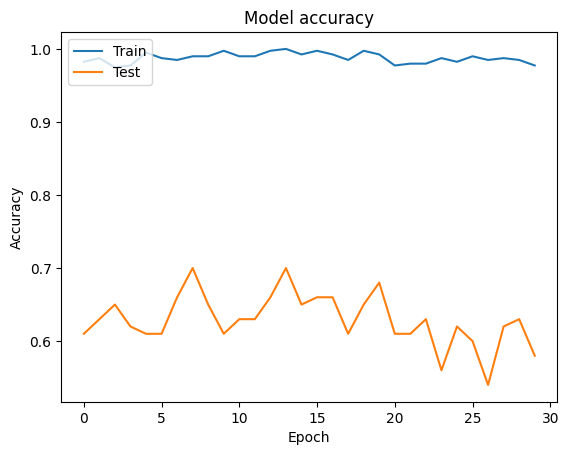

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have stored the training history in a variable named 'history'
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), callbacks=[print_progress])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
